# Text classification with an RNN

https://www.tensorflow.org/tutorials/text/text_classification_rnn

## Setup

The context words for each of the 8 words of this sentence are defined by a window size. The window size determines the span of words on either side of a `target_word` that can be considered context word. Take a look at this table of skip-grams for target words based on different window sizes.



In [1]:
import numpy as np

import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [2]:
# Setup memory to fix critical issue
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

### Setup input pipeline

In [4]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [5]:
for example, label in train_dataset.take(1):
    print('text: ', example.numpy())
    print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [8]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy()[:3])
    print()
    print('labels: ', label.numpy()[:3])

texts:  [b'Despite its flaws, I enjoyed "Cigarette Burns", John Carpenter\'s Season One episode in the Masters of Horror series. Yes, the story seemed like a cheap cross between IN THE MOUTH OF MADNESS and 8MM, but it was still quite good for the budget and time constraints given to it. With "Pro-Life", however, the low budget and time constraints definitely show more than anything else. There is solid directing as always from Carpenter yet there is a quality to the writing and whole production itself that gives the feeling it was made in a total and complete rush. The script isn\'t always clear, the message fuzzy, and the story is full of plot holes once you look back on them. Maybe had Carpenter re-written the script, it could have been a worthwhile episode. Instead, it\'s a mess that only hardcore Carpenter fans will find the slightest enjoyment in. Definitely the worst Carpenter has ever done. 2/10'
 b"The Good Thing about this movie: The concept is interesting and there are some f

### Create the text encoder

In [9]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [10]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [11]:
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[450,  30,   1, ...,   0,   0,   0],
       [  2,  50, 151, ...,   0,   0,   0],
       [ 10,  61, 208, ...,   0,   0,   0]], dtype=int64)

In [12]:
for n in range(3):
    print("Original: ", example[n].numpy())
    print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
    print()

Original:  b'Despite its flaws, I enjoyed "Cigarette Burns", John Carpenter\'s Season One episode in the Masters of Horror series. Yes, the story seemed like a cheap cross between IN THE MOUTH OF MADNESS and 8MM, but it was still quite good for the budget and time constraints given to it. With "Pro-Life", however, the low budget and time constraints definitely show more than anything else. There is solid directing as always from Carpenter yet there is a quality to the writing and whole production itself that gives the feeling it was made in a total and complete rush. The script isn\'t always clear, the message fuzzy, and the story is full of plot holes once you look back on them. Maybe had Carpenter re-written the script, it could have been a worthwhile episode. Instead, it\'s a mess that only hardcore Carpenter fans will find the slightest enjoyment in. Definitely the worst Carpenter has ever done. 2/10'
Round-trip:  despite its [UNK] i enjoyed [UNK] [UNK] john [UNK] season one episod

### Create the model

In [13]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [14]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [15]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

[-0.00082099]


In [16]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

[-0.00082099]


In [17]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

### Train the model

In [18]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 105ms/step - loss: 0.6823 - accuracy: 0.5097 - val_loss: 0.4940 - val_accuracy: 0.7833
Epoch 2/10
391/391 [==============================] - 39s 99ms/step - loss: 0.4132 - accuracy: 0.8090 - val_loss: 0.3680 - val_accuracy: 0.8203
Epoch 3/10
391/391 [==============================] - 39s 101ms/step - loss: 0.3377 - accuracy: 0.8507 - val_loss: 0.3417 - val_accuracy: 0.8490
Epoch 4/10
391/391 [==============================] - 40s 102ms/step - loss: 0.3148 - accuracy: 0.8628 - val_loss: 0.3278 - val_accuracy: 0.8557
Epoch 5/10
391/391 [==============================] - 40s 102ms/step - loss: 0.3095 - accuracy: 0.8641 - val_loss: 0.3209 - val_accuracy: 0.8630
Epoch 6/10
391/391 [==============================] - 39s 99ms/step - loss: 0.3058 - accuracy: 0.8701 - val_loss: 0.3327 - val_accuracy: 0.8615
Epoch 7/10
391/391 [==============================] - 39s 100ms/step - loss: 0.3059 - accuracy: 0.8682 - val_loss: 0.3205 - val_accu

In [19]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 51ms/step - loss: 0.3171 - accuracy: 0.8632
Test Loss: 0.3171176612377167
Test Accuracy: 0.8632400035858154


(0.0, 0.6526422768831253)

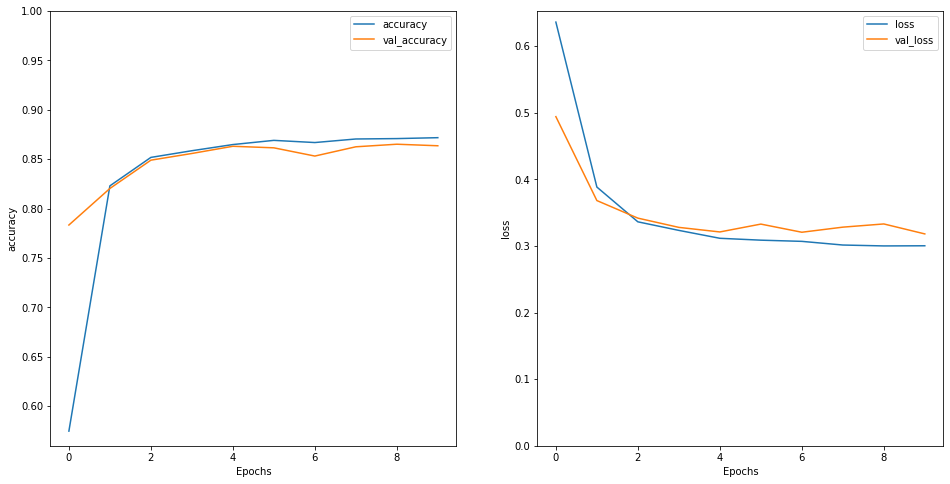

In [20]:
plt.figure(figsize=(16,8))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.ylim(None,1)
plt.subplot(1,2,2)
plot_graphs(history, 'loss')
plt.ylim(0,None)

In [21]:
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

### Stack two or more LSTM layers

In [22]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [23]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [24]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 79s 176ms/step - loss: 0.6760 - accuracy: 0.5250 - val_loss: 0.4383 - val_accuracy: 0.8193
Epoch 2/10
391/391 [==============================] - 66s 168ms/step - loss: 0.4008 - accuracy: 0.8219 - val_loss: 0.3429 - val_accuracy: 0.8411
Epoch 3/10
391/391 [==============================] - 63s 162ms/step - loss: 0.3425 - accuracy: 0.8523 - val_loss: 0.3236 - val_accuracy: 0.8609
Epoch 4/10
391/391 [==============================] - 64s 163ms/step - loss: 0.3256 - accuracy: 0.8602 - val_loss: 0.3484 - val_accuracy: 0.8562
Epoch 5/10
391/391 [==============================] - 65s 166ms/step - loss: 0.3139 - accuracy: 0.8662 - val_loss: 0.3163 - val_accuracy: 0.8609
Epoch 6/10
391/391 [==============================] - 65s 167ms/step - loss: 0.3058 - accuracy: 0.8697 - val_loss: 0.3167 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 66s 168ms/step - loss: 0.3062 - accuracy: 0.8699 - val_loss: 0.3228 - val_ac

In [25]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 28s 73ms/step - loss: 0.3273 - accuracy: 0.8464
Test Loss: 0.3273463547229767
Test Accuracy: 0.8464400172233582


In [26]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.622307]]


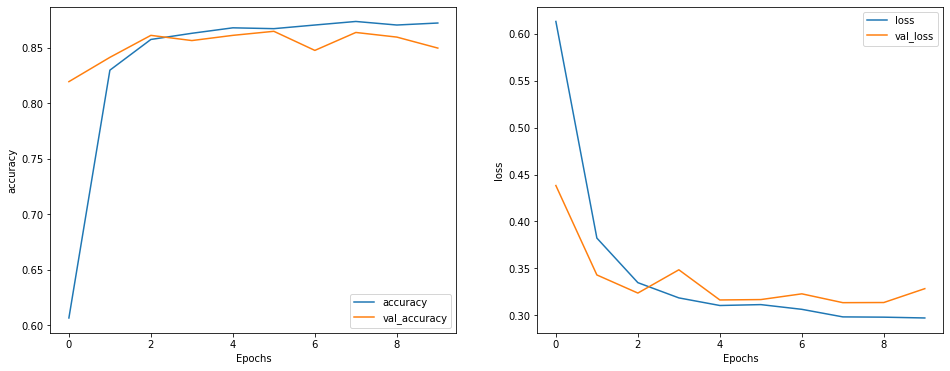

In [27]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')